In [1]:
experiment_name= "C2S_resnet34_semi_hard_margin_1_Ptr"

In [2]:
import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.core.common import flatten
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import datasets
import networks
import utils

In [3]:
#######################################################
#                  Create Dataset
#######################################################
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

'''
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ,
                              transforms.Normalize(mean, std)
                              ])
''' 

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

#######################################################
#                  Create Train Dataset
#######################################################
dataset_train = datasets.DeepFashionBBoxDataset(img_dir="../DeepFashion_C2S/images",train_path="../DeepFashion_C2S/DeepFashionDataset_train.csv",mode="train", transform= transform)

#######################################################
#                  Create Valid Dataset
#######################################################
dataset_valid = datasets.DeepFashionBBoxDataset(img_dir="../DeepFashion_C2S/images",validation_path="../DeepFashion_C2S/DeepFashionDataset_validation.csv",mode="validation", transform= transform)

#######################################################
#                  Create Test Dataset
#######################################################
dataset_test = datasets.DeepFashionBBoxDataset(img_dir="../DeepFashion_C2S/images",test_path="../DeepFashion_C2S/DeepFashionDataset_test.csv",mode="test", transform= transform)


In [4]:
len(dataset_train)

159062

In [5]:
len(dataset_train.classes_set)

17968

In [6]:
len(dataset_valid)

20106

In [7]:
dataset_train.labels[:100]

array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13,
       13, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
       16, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18])

In [8]:
dataset_train.data[:5]

['CLOTHING/Blouse/id_00005025/comsumer_01.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_02.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_03.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_04.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_05.jpg']

In [9]:
dataset_train.classes[:5]

['CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025']

In [12]:
batch_size= 4
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [13]:
images.shape

(4, 3, 224, 224)

In [14]:
labels

tensor([5138, 5002, 7359, 1084])

In [15]:
# labels to class names:
print([dataset_train.classes_set[i.item()] for i in labels ])

['TOPS/Lace_Shirt/id_00020489', 'TOPS/Lace_Shirt/id_00013462', 'TOPS/Summer_Wear/id_00010895', 'CLOTHING/T_Shirt/id_00030958']


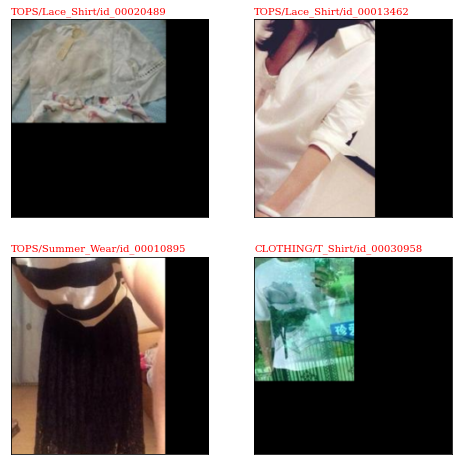

In [16]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_loader.dataset.classes_set[labels[idx].item()], fontfamily='serif', loc='left', fontsize='medium', color= 'red')
    

In [17]:
# check if CUDA is available
cuda = torch.cuda.is_available()

if not cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [18]:
dataset_train.labels

array([    0,     0,     0, ..., 17967, 17967, 17967])

In [19]:
from datasets import BalancedBatchSampler

# A mini batch is created by sampling n_classes and n_samples from each class:
train_batch_sampler = BalancedBatchSampler(dataset_train.labels, n_classes=20, n_samples=30)
valid_batch_sampler = BalancedBatchSampler(dataset_valid.labels, n_classes=20, n_samples=30)

In [30]:
train_batch_sampler

In [31]:
valid_batch_sampler

In [32]:
online_train_loader = torch.utils.data.DataLoader(dataset_train, batch_sampler=train_batch_sampler)
online_valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_sampler=valid_batch_sampler)

# Use pre-trained model on Kaggle Fashion items

In [ ]:
# Load the pretrained model from pytorch
embedding_net= torchvision.models.resnet34(pretrained=False)

embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 47) # Kaggle fashion items included 47 classes
                                )

experiment_name= "KaggleFashion_pretrain_classification_resnet34"
PATH= './Results/'+experiment_name+'_100epoch.pt'

check_point= torch.load(PATH)
embedding_net.load_state_dict(check_point['model_state_dict'])


In [ ]:
# Modify the final layer of the embedding network:
embedding_net.fc= nn.Sequential(nn.Linear(512, 256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Linear(256, 256), # embedding size 256
                                )

# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [44]:
model= networks.TripletNet(embedding_net)

In [45]:
from losses import OnlineTripletLoss
# Strategies for selecting triplets within a minibatch:
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector 

margin = 1
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))

In [46]:
import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.parameters(), lr=1e-3)

In [47]:
device = torch.device('cuda')
model.to(device)

TripletNet(
  (embedding_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [48]:
def train_epoch(train_loader, model, loss_fn, optimizer, log_interval, cuda):

    ###################
    # train the model #
    ###################
    model.train()

   # keep track of training loss
    train_loss = 0.0
    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):

        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        
        # move tensors to GPU if CUDA is available
        if cuda:
            data = tuple(d.to(device) for d in data)
            if target is not None:
                target = tuple(t.to(device) for t in target)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: create embeddings of the inputs
        outputs = model.get_embedding(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        # append targets to the end of the embeddings, and calculate the batch loss
        loss_outputs = loss_fn(*loss_inputs)
        
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()

        losses.append(loss.item())
        
        # Provide some feedbach within one epoch
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))
            losses = []

    # calculate average train loss (batch average is returned)
    train_loss /= (batch_idx + 1)
    
    return train_loss

In [49]:
def test_epoch(val_loader, model, loss_fn, cuda):
    
    ######################    
    # validate the model #
    ######################
    
    # keep track of validation loss
    valid_loss = 0.0
    
    with torch.no_grad():

        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            data= data.float() # cast to float

            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            
            if cuda:
                data = tuple(d.to(device) for d in data)
                if target is not None:
                    target = tuple(t.to(device) for t in target)
            
            outputs = model.get_embedding(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
                
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            
            # update average validation loss 
            valid_loss += loss.item()
            
    # calculate average validation loss (batch average is returned)
    valid_loss /= (batch_idx + 1)

    return valid_loss

In [52]:
def save_model(EPOCH, model, optimizer, LOSS): # epoch and loss are numbers
    """
    Save the trained model and the optimizer to disk.
    """      
    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.embedding_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, experiment_name+'.pt')

In [53]:
start_epoch= 0
n_epochs= 75

log_interval=50

train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(start_epoch, n_epochs):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_loss = train_epoch(online_train_loader, model, loss_fn, optimizer, log_interval, cuda)
    valid_loss = test_epoch(online_valid_loader, model, loss_fn, cuda)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, n_epochs, train_loss, valid_loss))
         
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( valid_loss_min,
                                                                                          valid_loss))
        save_model(epoch, model, optimizer, train_loss)
        valid_loss_min = valid_loss
    

Train: [0/159062 (0%)]	Loss: 0.554896
Train: [11800/159062 (19%)]	Loss: 0.528624
Train: [25700/159062 (38%)]	Loss: 0.509147
Train: [26250/159062 (57%)]	Loss: 0.516891
Train: [38000/159062 (75%)]	Loss: 0.519479
Train: [37000/159062 (94%)]	Loss: 0.510668
Epoch: Epoch: 1/75 	Training Loss: 0.517035 	Validation Loss: 0.533383
Validation loss decreased (inf --> 0.533383).  Saving model ...
Train: [0/159062 (0%)]	Loss: 0.492390
Train: [9400/159062 (19%)]	Loss: 0.518471
Train: [18300/159062 (38%)]	Loss: 0.513980
Train: [32700/159062 (57%)]	Loss: 0.516213
Train: [37000/159062 (75%)]	Loss: 0.507156
Train: [60000/159062 (94%)]	Loss: 0.519055
Epoch: Epoch: 2/75 	Training Loss: 0.515345 	Validation Loss: 0.506877
Validation loss decreased (0.533383 --> 0.506877).  Saving model ...
Train: [0/159062 (0%)]	Loss: 0.480982
Train: [8450/159062 (19%)]	Loss: 0.523729
Train: [14400/159062 (38%)]	Loss: 0.515828
Train: [27300/159062 (57%)]	Loss: 0.507582
Train: [43600/159062 (75%)]	Loss: 0.509293
Train: [517

Train: [0/159062 (0%)]	Loss: 0.614706
Train: [8950/159062 (19%)]	Loss: 0.563523
Train: [14500/159062 (38%)]	Loss: 0.554709
Train: [33150/159062 (57%)]	Loss: 0.555434
Train: [30200/159062 (75%)]	Loss: 0.557063
Train: [44250/159062 (94%)]	Loss: 0.548932
Epoch: Epoch: 26/75 	Training Loss: 0.556134 	Validation Loss: 0.564873
Train: [0/159062 (0%)]	Loss: 0.533178
Train: [8750/159062 (19%)]	Loss: 0.565421
Train: [15600/159062 (38%)]	Loss: 0.549595
Train: [27450/159062 (57%)]	Loss: 0.552903
Train: [43600/159062 (75%)]	Loss: 0.559281
Train: [39750/159062 (94%)]	Loss: 0.595612
Epoch: Epoch: 27/75 	Training Loss: 0.567555 	Validation Loss: 0.624589
Train: [0/159062 (0%)]	Loss: 0.685044
Train: [10050/159062 (19%)]	Loss: 0.641561
Train: [14200/159062 (38%)]	Loss: 0.655416
Train: [25200/159062 (57%)]	Loss: 0.683428
Train: [39400/159062 (75%)]	Loss: 0.652074
Train: [60750/159062 (94%)]	Loss: 0.677015
Epoch: Epoch: 28/75 	Training Loss: 0.663880 	Validation Loss: 0.637358
Train: [0/159062 (0%)]	Loss

Train: [18300/159062 (38%)]	Loss: 0.645506
Train: [28350/159062 (57%)]	Loss: 0.670024
Train: [28000/159062 (75%)]	Loss: 0.612149
Train: [45500/159062 (94%)]	Loss: 0.594843
Epoch: Epoch: 51/75 	Training Loss: 0.624055 	Validation Loss: 0.637650
Train: [0/159062 (0%)]	Loss: 0.667560
Train: [8050/159062 (19%)]	Loss: 0.611527
Train: [15800/159062 (38%)]	Loss: 0.623285
Train: [19350/159062 (57%)]	Loss: 0.638120
Train: [26400/159062 (75%)]	Loss: 0.666372
Train: [52500/159062 (94%)]	Loss: 0.688779
Epoch: Epoch: 52/75 	Training Loss: 0.644183 	Validation Loss: 0.699884
Train: [0/159062 (0%)]	Loss: 0.460899
Train: [9200/159062 (19%)]	Loss: 0.651637
Train: [15600/159062 (38%)]	Loss: 0.597407
Train: [28800/159062 (57%)]	Loss: 0.602753
Train: [39600/159062 (75%)]	Loss: 0.614181
Train: [46500/159062 (94%)]	Loss: 0.589383
Epoch: Epoch: 53/75 	Training Loss: 0.607344 	Validation Loss: 0.559317
Train: [0/159062 (0%)]	Loss: 0.543273
Train: [8150/159062 (19%)]	Loss: 0.579614
Train: [13100/159062 (38%)]	

NameError: name 'EPOCH' is not defined

In [55]:
torch.save({'epoch': 75,
            'model_state_dict': model.embedding_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 'too_much',
           }, experiment_name+'75epoch.pt')

In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

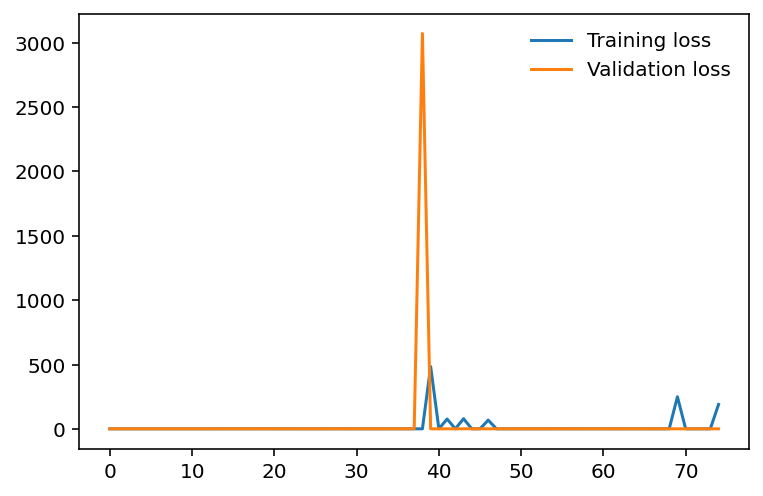

In [58]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [59]:
# write training results:
f = open(experiment_name+ "_result"+".csv", "w")
f.write('\t'.join(('tr_er', 'val_er')))
f.write('\n')
for (tr_er, val_er) in zip(train_losses, valid_losses,):
    items= (str(tr_er),',', str(val_er))
    f.write('\t'.join(items))
    f.write('\n')
f.close()

In [ ]:
# Load model and optimizer from disk:
embedding_net= torchvision.models.resnet18(pretrained=True)

# Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = False    
    
embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 128), # embedding size
                                )

model= networks.TripletNet(embedding_net)

import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.fc.parameters(), lr=1e-3)

PATH= experiment_name+'.pt'
check_point= torch.load(PATH)

model.embedding_net.load_state_dict(check_point['model_state_dict'])
optimizer.load_state_dict(check_point['optimizer_state_dict'])
epoch = check_point['epoch']
loss = check_point['loss']


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()